# Southern Ocean chosen density bins and contours

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import matplotlib as mpl


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44523/status,
Dashboard: /proxy/44523/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40961,Workers: 7
Dashboard: /proxy/44523/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:43551,Total threads: 4
Dashboard: /proxy/34739/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34281,


In [3]:
path = '/g/data/x77/cy8964/Post_Process/New_SO/Paper_Data/'

In [4]:
EKE = xr.open_dataset(path+'EKE_10yr.nc').EKE
MKE = xr.open_dataset(path+'MKE_10yr.nc').MKE
Reynolds = xr.open_dataset(path+'Reynolds_10yr.nc').Reynolds
Form_stress = xr.open_dataset(path+'Form_stress_10yr.nc').Form_stress
h_bar = xr.open_dataset(path+'h_bar_10yr.nc').h_bar

In [5]:
cmdict = cm.tools.get_dict(cm.cm.gray, N=19)
### get a discrete number of colours from an cmocean colormap

Load isopycnal depths

In [6]:
isopycnal_depth = xr.open_dataset(path+'h_bar_10yr.nc').h_bar
isopycnal_depth = isopycnal_depth.where(isopycnal_depth !=0).cumsum('isopycnal_bins')

In [7]:
plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})


Text(0, 0.5, 'st_ocean')

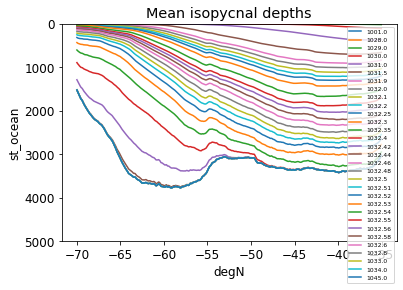

In [8]:
for i in isopycnal_depth.isopycnal_bins.values:
    isopycnal_depth.sel(isopycnal_bins=i, method = 'nearest').mean('xt_ocean').plot(label = i)
plt.legend(fontsize =6)
plt.ylim(5000,0)
plt.title('Mean isopycnal depths')
plt.xlabel('degN')
plt.ylabel('st_ocean')

In [9]:
cmdict = cm.tools.get_dict(cm.cm.dense, N=31)

In [10]:
pot_rho_1 = xr.open_dataset(path+'pot_rho_1_10yr.nc').pot_rho_1

In [11]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})


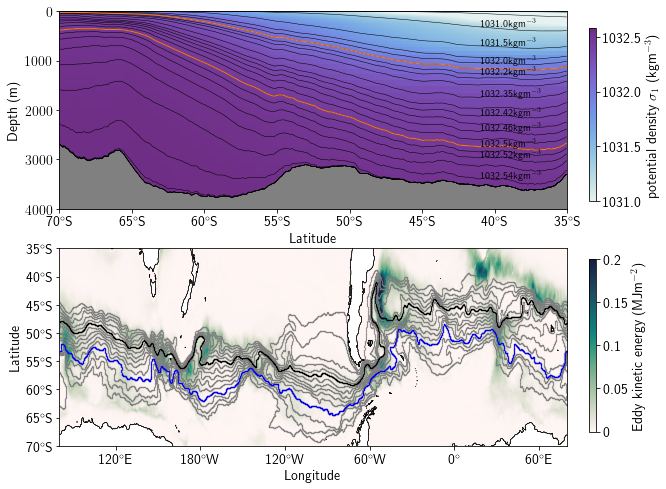

In [12]:
fig,axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,8))

p1 = ((EKE)/1e6).sum('isopycnal_bins').where(((EKE)/1e6).sum('isopycnal_bins') !=0).plot(ax = axes[1], vmax = 0.2, cmap = 'cmo.tempo', add_colorbar = False)
mask = (((EKE)/1e6).sum('isopycnal_bins').where(((EKE)/1e6).sum('isopycnal_bins') !=0)*0+1).fillna(0)
mask.plot.contour(colors = 'k', linewidths = 0.3)

# plot every second contour
for j in np.arange(14):
    i = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N'][j]
    SSH = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0,-1.1,-1.2,-1.3,-1.4][j]
    outfile = path+'SO_'+i+'_latlon.nc'
    lat_along_contour = xr.open_dataset(outfile).lat_along_contour
    lon_along_contour = xr.open_dataset(outfile).lon_along_contour
    axes[1].scatter(lon_along_contour,lat_along_contour,label = str(SSH),s = 0.02, color = 'grey')
## The -1.5 m contour doesn't start at 80E, due to the contour crossing 80E in 3 places
## (would otherwise not start and end at same longitude.) Have made shifted version:
j=14
SSH = -1.5
lat_along_contour = xr.open_dataset(path+'SO_O_latlon_shiftedback.nc').lat_along_contour
lon_along_contour = xr.open_dataset(path+'SO_O_latlon_shiftedback.nc').lon_along_contour
axes[1].scatter(lon_along_contour,lat_along_contour,label = str(SSH),s = 0.02, color = 'grey')

## Highlight -1.2 m and -0.6 m contours.
j=12
SSH = -1.2
lat_along_contour = xr.open_dataset(path+'SO_L_latlon.nc').lat_along_contour
lon_along_contour = xr.open_dataset(path+'SO_L_latlon.nc').lon_along_contour
axes[1].scatter(lon_along_contour,lat_along_contour,label = str(SSH),s = 0.02, color = 'b')

j=12
SSH = -0.6
lat_along_contour = xr.open_dataset(path+'SO_F_latlon.nc').lat_along_contour
lon_along_contour = xr.open_dataset(path+'SO_F_latlon.nc').lon_along_contour
axes[1].scatter(lon_along_contour,lat_along_contour,label = str(SSH),s = 0.02, color = 'k')

X = np.arange(-240,100,60)
axes[1].set_xticks(X)
axes[1].set_xticklabels(('120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
Y = np.arange(-70,-34,5)
axes[1].set_yticks(Y)
axes[1].set_yticklabels(('70$^\circ$S','65$^\circ$S','60$^\circ$S','55$^\circ$S','50$^\circ$S','45$^\circ$S','40$^\circ$S','35$^\circ$S'));
axes[1].set_ylabel('Latitude')
axes[1].set_xlabel('Longitude')

#fig.subplots_adjust(right = 0.77, bottom = 0.15)
#plt.legend(bbox_to_anchor=(1.05, 0.9),loc='upper left')
cbar_ax = fig.add_axes([0.86, 0.15, 0.01, 0.3])
plt.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Eddy kinetic energy (MJm$^{-2}$)')
Y = np.arange(0,0.21,0.05)
cbar_ax.set_yticks(Y)
cbar_ax.set_yticklabels(('0','0.05','0.1','0.15','0.2'));


## Isopycnal depths
isopycnal_depthnan = isopycnal_depth.where(isopycnal_depth!=0)
for i in range(len(isopycnal_depthnan.isopycnal_bins.values)):
    j = isopycnal_depthnan.isopycnal_bins.values[i]
    isopycnal_depthnan.sel(isopycnal_bins=j, method = 'nearest').mean('xt_ocean').plot(ax = axes[0],color = 'k', linewidth = 0.5)
    
for i in np.arange(2):
    j = np.array([1032.1,1032.5])[i]
    isopycnal_depthnan.sel(isopycnal_bins=j, method = 'nearest').mean('xt_ocean').plot(ax = axes[0],color = 'C1', linewidth = 1)

for j in np.array([1031.00  , 1031.50 , 
       1032.35, 
       1032.42,  1032.46,  1032.50 , 1032.52,
       1032.54]):   
    axes[0].text(-41,isopycnal_depthnan.sel(isopycnal_bins=j, method = 'nearest').mean('xt_ocean').sel(yt_ocean = -41, method = 'nearest').values-20,str(j)+'kgm$^{-3}$', fontsize = 10)

for j in np.array([1032.0, 1032.20]):   
    axes[0].text(-41,isopycnal_depthnan.sel(isopycnal_bins=j, method = 'nearest').mean('xt_ocean').sel(yt_ocean = -41, method = 'nearest').values+10,str(j)+'kgm$^{-3}$', fontsize = 10)

newcmap = cm.tools.crop_by_percent(cm.cm.dense, 25, which='max', N= None)
p1 = pot_rho_1.where(pot_rho_1 !=0).sel(yt_ocean = slice(-70,-35)).mean('xt_ocean').plot(ax = axes[0],cmap = newcmap, yincrease = False, vmin = 1031, add_colorbar = False)

axes[0].fill_between(isopycnal_depthnan.yt_ocean, isopycnal_depthnan.sel(isopycnal_bins=j+1, method = 'nearest').mean('xt_ocean'),5000, color = 'grey')
axes[0].set_ylim(4000,0)
axes[0].set_xlim(-70,-35)
X = np.arange(-70,-34,5)
axes[0].set_xticks(X, ('70$^\circ$S','65$^\circ$S','60$^\circ$S','55$^\circ$S','50$^\circ$S','45$^\circ$S','40$^\circ$S','35$^\circ$S'));
axes[0].set_title('')#Zonal mean density ($\sigma_1$) layer thickness and depths')

axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Depth (m)')

ax_cb = plt.axes([0.86, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('potential density $\sigma_1$ (kgm$^{-3}$)');
cb.ax.set_yticklabels(('1031.0','1031.5','1032.0','1032.5'));

fig.subplots_adjust(right = 0.83)

fig.savefig('Fig3-density_layers_SSH_contours.png',dpi = 400)